Este notebook toma los archivos json y los procesa con la librería datasets de Huggingface. Durante el procesado, el texto y las entidades se fusionan en un mismo prompt que será utilizado para el fine-tuning de GPT-J.

In [2]:
!pip install datasets

Añade todos los paths de los jsons que quieras utilizar para el fine-tuning:

In [9]:
# Podcasts procesados por Sergio de Deforme Semanal
list_json_sergio = ['/home/sergiop/hackathon_podcast/data/NER/json_entity/output_' + str(i) + '.json' for i in range(12)]
# Podcasts procesados por Alberto
list_json_alberto = ['/home/sergiop/hackathon_podcast/data/NER/json_entity/json_files_alberto/output_' + str(i) + '.json' for i in range(18)]

list_all_json = list_json_sergio + list_json_alberto
print(list_all_json)

['/home/sergiop/hackathon_podcast/data/NER/json_entity/output_0.json', '/home/sergiop/hackathon_podcast/data/NER/json_entity/output_1.json', '/home/sergiop/hackathon_podcast/data/NER/json_entity/output_2.json', '/home/sergiop/hackathon_podcast/data/NER/json_entity/output_3.json', '/home/sergiop/hackathon_podcast/data/NER/json_entity/output_4.json', '/home/sergiop/hackathon_podcast/data/NER/json_entity/output_5.json', '/home/sergiop/hackathon_podcast/data/NER/json_entity/output_6.json', '/home/sergiop/hackathon_podcast/data/NER/json_entity/output_7.json', '/home/sergiop/hackathon_podcast/data/NER/json_entity/output_8.json', '/home/sergiop/hackathon_podcast/data/NER/json_entity/output_9.json', '/home/sergiop/hackathon_podcast/data/NER/json_entity/output_10.json', '/home/sergiop/hackathon_podcast/data/NER/json_entity/output_11.json', '/home/sergiop/hackathon_podcast/data/NER/json_entity/json_files_alberto/output_0.json', '/home/sergiop/hackathon_podcast/data/NER/json_entity/json_files_alb

Usa la librería `datasets` de Huggingface para procesar los jsons

In [116]:
import json
from datasets import Dataset

def load_custom_dataset(paths):
    texts = []
    entities = []
    for path in paths:
        with open(path, 'r') as f:
            data = json.load(f)
        texts.extend([item['text'] for item in data])
        entities.extend([item['entities'] for item in data])
    return Dataset.from_dict({'text': texts, 'entities': entities})

dataset = load_custom_dataset(list_all_json)

In [117]:
print(dataset['text'][0])  # prints the first text in the dataset
print(dataset['entities'][0][0])  # prints the first list of entities in the dataset

Yo hoy voy a hablar de mujeres en el mundo del arte, porque me ha leído un libro fantástico que se llama Historia del arte sin hombres, de Katie Hesel.

{'class': 'people', 'text': 'Katie Hesel'}


Crea el prompt a partir del texto y las entidades en los jsons

In [118]:
def form_training_prompts(example):
    text = example["text"]
    text = text[:-1]
    entities_list = example["entities"]
    entities = ""
    
    if entities_list: # Process only text with entities
        for entity in entities_list:
            if entity['class'] and entity['class'] != 'None' and entity['class'] != 'none' and entity['text']:
                entities = entities + '(' + entity['class'] + ', ' + entity['text'] + '), '
        entities = entities[:-2]
        
        if entities:
            example[
                "prompt"
            ] = f"text: {text} entities: {entities}<|endoftext|>"
        else:
            example["prompt"] = None
            
        return example

    else: # if the text doesn't include entities, return None
        example["prompt"] = None
        return example

Elimina las entradas que no contengan ninguna entidad, y utiliza la función `map` para generar los prompts

In [119]:
dataset = dataset.filter(lambda example: example is not None)

dataset = dataset.map(
    form_training_prompts,
    remove_columns=["text", "entities"],
    load_from_cache_file=False,
    desc="Generating text prompt",
)

dataset = dataset.filter(lambda example: example["prompt"] is not None)

Filter:   0%|          | 0/2656 [00:00<?, ? examples/s]

Generating text prompt:   0%|          | 0/2656 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2656 [00:00<?, ? examples/s]

Veamos cuántas entradas tenemos en el dataset, y algunos ejemplos

In [120]:
print(f'The number of samples in this dataset is: {len(dataset)}')
print(dataset[0])
print(dataset[1])

The number of samples in this dataset is: 2504
{'prompt': 'text: Yo hoy voy a hablar de mujeres en el mundo del arte, porque me ha leído un libro fantástico que se llama Historia del arte sin hombres, de Katie Hesel. entities: (people, Katie Hesel), (books, Historia del arte sin hombres)<|endoftext|>'}
{'prompt': 'text: Lo que hace Katie Hesel en este libro es el resultado de las exposiciones y decir que otra vez no hay mujeres en esta exposición, como todo el tiempo. entities: (people, Katie Hesel), (books, este libro)<|endoftext|>'}


In [121]:
max_length = 0
for example in dataset:
    prompt_length = len(example["prompt"])
    if prompt_length > max_length:
        max_length = prompt_length

print("Longest prompt length:", max_length)

Longest prompt length: 840


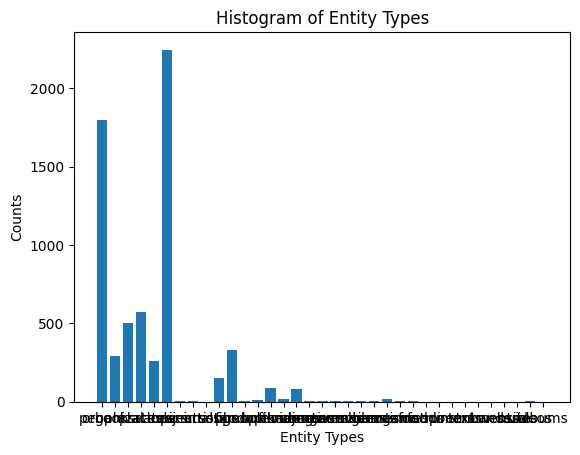

entity: people, counts: 1796
entity: books, counts: 292
entity: organizations, counts: 502
entity: places, counts: 571
entity: dates, counts: 262
entity: topics, counts: 2247
entity: objects, counts: 5
entity: animals, counts: 5
entity: artista, counts: 1
entity: songs, counts: 152
entity: films, counts: 327
entity: products, counts: 4
entity: topic, counts: 11
entity: people names, counts: 85
entity: book names, counts: 19
entity: film names, counts: 84
entity: adjectives, counts: 3
entity: song names, counts: 5
entity: videogame names, counts: 7
entity: numbers, counts: 2
entity: actions, counts: 5
entity: genres, counts: 4
entity: videogames, counts: 15
entity: time, counts: 2
entity: food, counts: 5
entity: foods, counts: 1
entity: instrument, counts: 1
entity: poems, counts: 1
entity: texts, counts: 1
entity: instruments, counts: 1
entity: bands, counts: 1
entity: website, counts: 1
entity: series, counts: 1
entity: videos, counts: 2
entity: albums, counts: 1


In [122]:
# ! pip install matplotlib
from collections import defaultdict
import matplotlib.pyplot as plt

# Initialize a dictionary to count the entities
entity_counts = defaultdict(int)

# Iterate through the dataset and extract the entities
for data in dataset:
    entities = data['prompt'].split('entities: ')[-1]
    entities = entities.split('), ')
    for entity in entities:
        try:
            entity_type, entity_name = entity.split(', ')
            entity_counts[entity_type[1:]] += 1
        except: # a few phrases have a comma in them and that makes parsing tricky
            pass

        

# Create a histogram of the entity counts
plt.bar(range(len(entity_counts)), list(entity_counts.values()), align='center')
plt.xticks(range(len(entity_counts)), list(entity_counts.keys()))
plt.xlabel('Entity Types')
plt.ylabel('Counts')
plt.title('Histogram of Entity Types')
plt.show()

# Print the dictionary

for k, v in entity_counts.items():
    print(f'entity: {k}, counts: {v}')

Carguemos en tokenizer de español del proyecto bertin gpt-j

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bertin-project/bertin-gpt-j-6B")
tokenizer.add_special_tokens({"pad_token": "<|extratoken_1|>"})  # index ?

1

Aplicamos el tokenizer sobre nuestro dataset

In [124]:
def tokenizes_text(tokenizer):
    def func(dataset):
        tokenized = tokenizer(dataset["prompt"], return_attention_mask=False, return_tensors="np", padding="max_length", truncation=True, max_length=max_length)
        return tokenized

    return func

# Tokenize prompts
dataset = dataset.map(
    tokenizes_text(tokenizer),
    batched=True,
    batch_size=10,
    num_proc=1,
    remove_columns=dataset.column_names,
    load_from_cache_file=False,
    desc="Tokenizing text",
)

Tokenizing text:   0%|          | 0/2504 [00:00<?, ? examples/s]

Ponemos el dataset en paquetes para ahorrar espacio y eliminar pad tokens. Además, creamos labels que son iguales que los prompts pero desplazadas una unidad a la derecha.

In [129]:
from itertools import chain


def group_texts():
    seq_len_1 = 840 + 1

    def func(examples):
        # Concatenate all texts.
        inputs = list(chain(*examples["input_ids"]))
        total_length = len(inputs)
        # We drop the small remainder instead of padding
        if total_length >= seq_len_1:
            total_length = (total_length // seq_len_1) * seq_len_1
        # Split by chunks of max_len.
        data = [inputs[i : i + seq_len_1] for i in range(0, total_length, seq_len_1)]
        result = {
            "input_ids": [d[:-1] for d in data],
            "labels": [d[1:] for d in data],
        }
        return result

    return func

# Pack tokenized prompts into sequences and split sequences in input_ids and labels
dataset = dataset.map(
    group_texts(),
    batched=True,
    batch_size=1000,
    num_proc=1,
    load_from_cache_file=False,
    desc="Packing sequences",
)

Packing sequences:   0%|          | 0/2504 [00:00<?, ? examples/s]

Comprobemos que los input_ids y los labels son identicos pero desplazados una unidad

In [130]:
print(len(dataset))
# Show a portion of first sentence. You can see that the label is the input shifted by one.
print("first 10 tokens of first sentence")
print("input_ids")
print(dataset["input_ids"][0][:10])
print("labels - shifted by one")
print(dataset["labels"][0][:10])

2499
first 10 tokens of first sentence
input_ids
[5239, 25, 25455, 289, 726, 23291, 257, 387, 2436, 283]
labels - shifted by one
[25, 25455, 289, 726, 23291, 257, 387, 2436, 283, 390]


### Descargar el checkpoint y probar a hacer inferencia

Por ahora el código siguiente no me funciona. El kernel muere, seguramente por falta de memoria. Lo podemos reducir más?

In [ ]:
from transformers.models.gptj.modeling_gptj import GPTJForCausalLM
import torch

if torch.cuda.is_available():
    pretrained = GPTJForCausalLM.from_pretrained(r"bertin-project/bertin-gpt-j-6B", torch_dtype=torch.float16).cuda()
else:
    pretrained = GPTJForCausalLM.from_pretrained(r"bertin-project/bertin-gpt-j-6B", torch_dtype=torch.float16)

Hagamos un poco de inferencia primero para ver cómo el modelo se comporta

In [ ]:
input_text = "Hola mi nombre es Sergio y"
input_ids = tokenizer.encode(str(input_text), return_tensors='pt').cuda()

output = pretrained.generate(
    input_ids,
    do_sample=True,
    max_length=20,
    top_p=0.7,
    top_k=0,
    temperature=1.0,
)
print(output)

### Configurar el trainer

In [ ]:
from transformers import Trainer, GPTJConfig

config = GPTJConfig()
config.training.steps = 2

In [ ]:
trainer = Trainer(
    model=pretrained
    config=config,
    train_dataset=dataset,
    tokenizer=tokenizer
)

True
